In [2]:
# wav = "./audio/Pages/Masu/1_Affirmative/3_食べます_たべます_to eat_0_L2.wav"
wav = "./audio/Pages/Masu/1_Affirmative/13_勉強します_べんきょうします_to study_0_L2.wav"
kana = "べんきょうします"


In [3]:
import librosa
import soundfile
data, sample_rate = librosa.load(wav, mono=False)
data_mono = librosa.to_mono(data)
soundfile.write("align/word.wav", data_mono, sample_rate)

In [4]:
len(data_mono) / sample_rate

1.1500226757369614

In [5]:
with open("align/word.txt", "w") as f:
    f.write(f"0.0,{len(data_mono)/sample_rate},{kana}")

In [6]:
from pyjuliusalign import alignFromTextgrid

In [7]:
soxPath = "/usr/bin/sox"
cabochaPath = "/usr/local/bin/cabocha"
perlPath = "/usr/bin/perl"
juliusScriptPath = "/home/murtaza/segmentation-kit/segment_julius.pl"
import os
os.environ["LD_LIBRARY_PATH"] = "/usr/local/lib"

alignFromTextgrid.convertCorpusToKanaAndRomaji(
    inputPath="align",
    outputPath="align/cabocha_out",
    cabochaEncoding="utf-8",
    cabochaPath=cabochaPath,
    encoding="utf-8",
)
alignFromTextgrid.forceAlignCorpus(
    wavPath="align",
    txtPath="align/cabocha_out/",
    outputPath="align/output",
    juliusScriptPath=juliusScriptPath,
    soxPath=soxPath,
    perlPath=perlPath,
)



Number of transcripts converted: 1
Number of unnamed entities: 0
Number of unidentified utterances: 0
Number of words processed without error: 2
/usr/bin/perl /home/murtaza/segmentation-kit/segment_julius.pl /home/murtaza/yale/koutei/align/align_tmp
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned for word
====Summary====
1 intervals of 1 total intervals (100.00%) and 2 phones of 2 total phones (100.00%) successfully aligned


enter filename->.................................................................................................................enter filename->1 files processed


In [8]:
from praatio import tgio
tg = tgio.openTextgrid("align/output/word.TextGrid")

In [9]:
alignment = tg.tierDict["phones_word"].entryList
onsets = [(interval.start, interval.label) for interval in alignment[1:]]
onsets

[(0.0725, 'b'),
 (0.1025, 'e'),
 (0.1825, 'N'),
 (0.3325, 'ky'),
 (0.4325, 'o:'),
 (0.5425, 'sh'),
 (0.6825, 'i'),
 (0.7125, 'm'),
 (0.7925, 'a'),
 (0.8725, 's'),
 (0.9925, 'u'),
 (1.1125, 'silE')]

In [10]:
kana_to_phones = {
    "た": "t",
    "べ": "b",
    "ま": "m",
    "す": "s",
    "ん": "N",
    "き": "k",
    "し": "sh",
    "う": "u",
}

In [14]:
def align_onsets_kana(onsets, kana):
    i = 0
    j = 0
    kana_offsets = []
    while i < len(kana):
        if kana[i] == "ょ":
            time, old_kana = kana_offsets[-1]
            kana_offsets[-1] = (time, old_kana + "ょ")
            if kana[i+1] == "う":
                while onsets[j][1] != "o:":
                    j += 1
                kana_offsets.append((onsets[j][0], "う"))
                i += 2
            else: #not sure if this works
                while onsets[j][1] != "o":
                    j += 1
                i += 1
        else:
            onset_ipa = kana_to_phones[kana[i]]
            while not onsets[j][1].startswith(onset_ipa):
                j += 1
            kana_offsets.append((onsets[j][0], kana[i]))
            i += 1
    kana_offsets.append((onsets[-1][0], "$"))
    return kana_offsets


In [15]:
align_onsets_kana(onsets, kana)

[(0.0725, 'べ'),
 (0.1825, 'ん'),
 (0.3325, 'きょ'),
 (0.4325, 'う'),
 (0.5425, 'し'),
 (0.7125, 'ま'),
 (0.8725, 'す'),
 (1.1125, '$')]

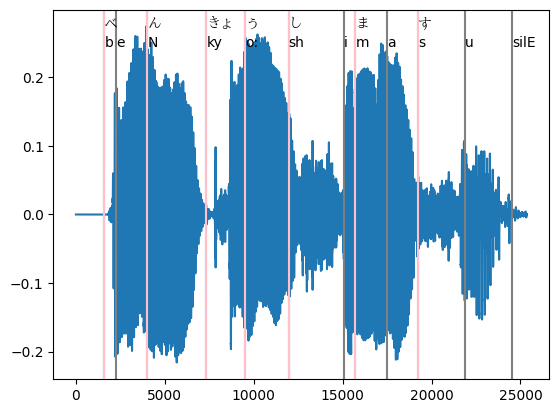

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(data_mono)
for time, label in onsets:
    ax.axvline(
        time * sample_rate,
        -1, 1,
        color="grey",
    )
    ax.text(time * sample_rate, 0.9, label, transform=ax.get_xaxis_transform())
for time, label in align_onsets_kana(onsets, kana):
    ax.axvline(
        time * sample_rate,
        -1, 1,
        color="pink",
    )
    ax.text(time * sample_rate,
        0.95,
        label,
        transform=ax.get_xaxis_transform(),
        fontname="TakaoMincho"
    )